In [3]:
import nltk
import itertools
import numpy as np 
from datetime import datetime
import sys

import theano as theano
import theano.tensor as T

import matplotlib.pyplot as plt
from IPython import display

In [4]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\MADHAVI\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Reading a files and combining into one single files

In [5]:
from glob import glob as gb 

dataset = []
for i in gb("dataset/*.txt"):
    with open(i,"rb") as file:
        dataset.append(file.read().decode("utf-8"))

# Task 1 : Character level Vanilla RNN


In [6]:
data = " ".join(dataset)

In [7]:
data = data.replace(" ","")

In [8]:
#Process data and calculate indexes
chars = list(set(data))
data_size, X_size = len(data), len(chars)
print("data has %d characters, %d unique" % (data_size, X_size))
char_to_idx = {ch:i for i,ch in enumerate(chars)}
idx_to_char = {i:ch for i,ch in enumerate(chars)}

data has 1696484 characters, 101 unique


In [9]:
data_size

1696484

In [10]:
X_size

101

In [11]:
XTrain = np.asarray([[char_to_idx[w] for w in sent[:-1]] for sent in data.split()])
yTrain = np.asarray([[char_to_idx[w] for w in sent[1:]] for sent in data.split()])

C:\Users\MADHAVI\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [12]:
XTrain

array([list([76, 90, 48, 85, 67, 97, 40, 48, 28, 60, 15, 92, 60, 48, 78, 26, 48, 67, 47, 41, 55, 97, 97, 8, 97, 46, 76, 90, 48, 57, 43, 33, 60, 48, 67, 39, 97, 92, 33, 21, 33, 100, 59, 78, 66, 88, 26, 43, 45, 92, 100, 48, 33, 74, 48, 67, 78]),
       list([76, 90, 39, 33, 48, 55, 97, 97, 8, 39, 33, 46, 97, 67, 60, 90, 48, 92, 33, 48, 97, 46, 59, 78, 43, 97, 78, 48, 59, 78, 43, 71, 90, 48, 67, 48, 59, 60, 78, 97, 28, 97, 33, 60, 59, 78, 66, 71, 39, 60]),
       list([59, 100, 32, 97, 33, 60, 78, 97, 67, 48, 33, 60, 67, 39, 28, 60, 39, 97, 78, 33, 71, 90, 59, 60, 33, 97, 48, 94, 48, 67, 80, 75, 97, 92, 32, 59, 43, 28, 97, 99, 43, 39, 60, 88, 47, 39, 94, 48, 39, 60, 59, 71, 59, 43, 97]),
       ...,
       list([61, 75, 97, 92, 59, 67, 48, 47, 97, 39, 78, 47, 60, 97, 99, 92, 60, 60, 97, 33, 48, 59, 50]),
       list([61, 21, 78, 59, 78, 90, 97, 92, 67, 80]),
       list([61, 75, 97, 92, 59, 67, 48, 26, 97, 92, 78, 66, 46, 97])],
      dtype=object)

In [13]:
# Print an training data example
x_example, y_example = XTrain[11], yTrain[11]
print ("x:\n%s\n%s" % (" ".join([idx_to_char[x] for x in x_example]), x_example))
print ("\ny:\n%s\n%s" % (" ".join([idx_to_char[x] for x in y_example]), y_example))

x:
C h a r a c t e r s e t e n c o d i n g : U T F -
[18, 90, 59, 67, 59, 28, 60, 48, 67, 33, 48, 60, 48, 78, 28, 97, 66, 39, 78, 47, 52, 19, 76, 56, 24]

y:
h a r a c t e r s e t e n c o d i n g : U T F - 8
[90, 59, 67, 59, 28, 60, 48, 67, 33, 48, 60, 48, 78, 28, 97, 66, 39, 78, 47, 52, 19, 76, 56, 24, 82]


In [14]:
def softmax(x):
        xt = np.exp(x - np.max(x))
        return xt / np.sum(xt)

In [15]:
#https://gist.github.com/karpathy/d4dee566867f8291f086
#https://theano-pymc.readthedocs.io/en/stable/tutorial/loading_and_saving.html
#https://github.com/Theano/Theano/issues/4173
#
def save_model_parameters_theano(outfile, model):
    U, V, W = model.U.get_value(), model.V.get_value(), model.W.get_value()
    np.savez(outfile, U=U, V=V, W=W)
    print ("Saved model parameters to %s." % outfile)
    
def load_model_parameters_theano(path, model):
    npzfile = np.load(path)
    U, V, W = npzfile["U"], npzfile["V"], npzfile["W"]
    model.hidden_dim = U.shape[0]
    model.word_dim = U.shape[1]
    model.U.set_value(U)
    model.V.set_value(V)
    model.W.set_value(W)
    print ("Loaded model parameters from %s. hidden_dim=%d word_dim=%d" % (path, U.shape[0], U.shape[1]))

class RNNTheano:
    
    def __init__(self, word_dim, hidden_dim=100, bptt_truncate=4):
        # Assign instance variables
        self.word_dim = word_dim
        self.hidden_dim = hidden_dim
        self.bptt_truncate = bptt_truncate
        # Randomly initialize the network parameters
        U = np.random.uniform(-np.sqrt(1./word_dim), np.sqrt(1./word_dim), (hidden_dim, word_dim))
        V = np.random.uniform(-np.sqrt(1./hidden_dim), np.sqrt(1./hidden_dim), (word_dim, hidden_dim))
        W = np.random.uniform(-np.sqrt(1./hidden_dim), np.sqrt(1./hidden_dim), (hidden_dim, hidden_dim))
        # Theano: Created shared variables
        self.U = theano.shared(name='U', value=U.astype(theano.config.floatX))
        self.V = theano.shared(name='V', value=V.astype(theano.config.floatX))
        self.W = theano.shared(name='W', value=W.astype(theano.config.floatX))      
        # We store the Theano graph here
        self.theano = {}
        self.__theano_build__()
    
    def __theano_build__(self):
        U, V, W = self.U, self.V, self.W
        x = T.ivector('x')
        y = T.ivector('y')
        def forward_prop_step(x_t, s_t_prev, U, V, W):
            s_t = T.tanh(U[:,x_t] + W.dot(s_t_prev))
            o_t = T.nnet.softmax(V.dot(s_t))
            return [o_t[0], s_t]
        [o,s], updates = theano.scan(
            forward_prop_step,
            sequences=x,
            outputs_info=[None, dict(initial=T.zeros(self.hidden_dim))],
            non_sequences=[U, V, W],
            truncate_gradient=self.bptt_truncate,
            strict=True)
        
        prediction = T.argmax(o, axis=1)
        o_error = T.sum(T.nnet.categorical_crossentropy(o, y))
        
        # Gradients
        dU = T.grad(o_error, U)
        dV = T.grad(o_error, V)
        dW = T.grad(o_error, W)
        
        # Assign functions
        self.forward_propagation = theano.function([x], o)
        self.predict = theano.function([x], prediction)
        self.ce_error = theano.function([x, y], o_error)
        self.bptt = theano.function([x, y], [dU, dV, dW])
        
        # SGD
        learning_rate = T.scalar('learning_rate')
        self.sgd_step = theano.function([x,y,learning_rate], [], 
                      updates=[(self.U, self.U - learning_rate * dU),
                              (self.V, self.V - learning_rate * dV),
                              (self.W, self.W - learning_rate * dW)])
   # https://github.com/keras-team/keras/issues/5013
#https://github.com/Theano/Theano/blob/master/theano/gradient.py
    def calculate_total_loss(self, X, Y):
        return np.sum([self.ce_error(x,y) for x,y in zip(X,Y)])
    
    def calculate_loss(self, X, Y):
        # Divide calculate_loss by the number of words
        num_words = np.sum([len(y) for y in Y])
        return self.calculate_total_loss(X,Y)/float(num_words)   

In [16]:
def train_with_sgd(model, X_train, y_train, learning_rate=0.005, nepoch=100, evaluate_loss_after=5):
    # We keep track of the losses so we can plot them later
    losses = []
    num_examples_seen = 0
    for epoch in range(nepoch):
        # Optionally evaluate the loss
        if (epoch % evaluate_loss_after == 0):
            loss = model.calculate_loss(X_train, y_train)
            losses.append((num_examples_seen, loss))
            time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
            print ("%s: Loss after num_examples_seen=%d epoch=%d: %f" % (time, num_examples_seen, epoch, loss))
            # Adjust the learning rate if loss increases
            if (len(losses) > 1 and losses[-1][1] > losses[-2][1]):
                learning_rate = learning_rate * 0.5 
                print ("Setting learning rate to %f" % learning_rate)
            sys.stdout.flush()
        # For each training example...
        for i in range(len(y_train)):
            # One SGD step
            model.sgd_step(X_train[i], y_train[i], learning_rate)
            num_examples_seen += 1

In [ ]:
model = RNNTheano(len(set(chars)), hidden_dim=50)
losses = train_with_sgd(model, XTrain[:2000], yTrain[:2000], nepoch=50)

C:\Users\MADHAVI\AppData\Local\Temp/ipykernel_29400/533260549.py:41: UserWarning: DEPRECATION: If x is a vector, Softmax will not automatically pad x anymore in next releases. If you need it, please do it manually. The vector case is gonna be supported soon and the output will be a vector.
  o_t = T.nnet.softmax(V.dot(s_t))


2022-04-23 15:48:00: Loss after num_examples_seen=0 epoch=0: 4.616087
2022-04-23 16:25:35: Loss after num_examples_seen=10000 epoch=5: 2.842811


# Task 2: Character level LSTM RNN

In [6]:
data = " ".join(dataset)
data = data.replace(" ","")

In [7]:
#Process data and calculate indexes
chars = list(set(data))
data_size, X_size = len(data), len(chars)
print("data has %d characters, %d unique" % (data_size, X_size))
char_to_idx = {ch:i for i,ch in enumerate(chars)}
idx_to_char = {i:ch for i,ch in enumerate(chars)}

data has 2006312 characters, 102 unique


In [8]:
data_size

2006312

In [9]:
X_size

102

In [10]:
# Constants and hyper-params
H_size = 100 # Size of the hidden layer
T_steps = 25 # Number of time steps (length of the sequence) used for training
learning_rate = 1e-1 # Learning rate
weight_sd = 0.1 # Standard deviation of weights for initialization
z_size = H_size + X_size # Size of concatenate(H, X) vector

In [11]:
#https://medium.com/deep-learning-with-keras/char-level-text-generation-with-an-lstm-model-e55ba7ff18c2
#https://github.com/karpathy/char-rnn
#https://github.com/viritaromero/Character-Level-LSTM-in-Pytorch
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def dsigmoid(y):
    return y * (1 - y)

def tanh(x):
    return np.tanh(x)

def dtanh(y):
    return 1 - y * y


class Param:
    def __init__(self, name, value):
        self.name = name
        self.v = value #parameter value
        self.d = np.zeros_like(value) #derivative
        self.m = np.zeros_like(value) #momentum for AdaGrad

    
class Parameters:
    def __init__(self):
        self.W_f = Param('W_f', 
                         np.random.randn(H_size, z_size) * weight_sd + 0.5)
        self.b_f = Param('b_f',
                         np.zeros((H_size, 1)))

        self.W_i = Param('W_i',
                         np.random.randn(H_size, z_size) * weight_sd + 0.5)
        self.b_i = Param('b_i',
                         np.zeros((H_size, 1)))

        self.W_C = Param('W_C',
                         np.random.randn(H_size, z_size) * weight_sd)
        self.b_C = Param('b_C',
                         np.zeros((H_size, 1)))

        self.W_o = Param('W_o',
                         np.random.randn(H_size, z_size) * weight_sd + 0.5)
        self.b_o = Param('b_o',
                         np.zeros((H_size, 1)))

        #For final layer to predict the next character
        self.W_v = Param('W_v',
                         np.random.randn(X_size, H_size) * weight_sd)
        self.b_v = Param('b_v',
                         np.zeros((X_size, 1)))
        
    def all(self):
        return [self.W_f, self.W_i, self.W_C, self.W_o, self.W_v,
               self.b_f, self.b_i, self.b_C, self.b_o, self.b_v]
        
parameters = Parameters()

def forward(x, h_prev, C_prev, p = parameters):
    assert x.shape == (X_size, 1)
    assert h_prev.shape == (H_size, 1)
    assert C_prev.shape == (H_size, 1)
    
    z = np.row_stack((h_prev, x))
    f = sigmoid(np.dot(p.W_f.v, z) + p.b_f.v)
    i = sigmoid(np.dot(p.W_i.v, z) + p.b_i.v)
    C_bar = tanh(np.dot(p.W_C.v, z) + p.b_C.v)

    C = f * C_prev + i * C_bar
    o = sigmoid(np.dot(p.W_o.v, z) + p.b_o.v)
    h = o * tanh(C)

    v = np.dot(p.W_v.v, h) + p.b_v.v
    y = np.exp(v) / np.sum(np.exp(v)) #softmax

    return z, f, i, C_bar, C, o, h, v, y


def backward(target, dh_next, dC_next, C_prev,
             z, f, i, C_bar, C, o, h, v, y,
             p = parameters):
    
    assert z.shape == (X_size + H_size, 1)
    assert v.shape == (X_size, 1)
    assert y.shape == (X_size, 1)
    
    for param in [dh_next, dC_next, C_prev, f, i, C_bar, C, o, h]:
        assert param.shape == (H_size, 1)
        
    dv = np.copy(y)
    dv[target] -= 1

    p.W_v.d += np.dot(dv, h.T)
    p.b_v.d += dv

    dh = np.dot(p.W_v.v.T, dv)        
    dh += dh_next
    do = dh * tanh(C)
    do = dsigmoid(o) * do
    p.W_o.d += np.dot(do, z.T)
    p.b_o.d += do

    dC = np.copy(dC_next)
    dC += dh * o * dtanh(tanh(C))
    dC_bar = dC * i
    dC_bar = dtanh(C_bar) * dC_bar
    p.W_C.d += np.dot(dC_bar, z.T)
    p.b_C.d += dC_bar

    di = dC * C_bar
    di = dsigmoid(i) * di
    p.W_i.d += np.dot(di, z.T)
    p.b_i.d += di

    df = dC * C_prev
    df = dsigmoid(f) * df
    p.W_f.d += np.dot(df, z.T)
    p.b_f.d += df

    dz = (np.dot(p.W_f.v.T, df)
         + np.dot(p.W_i.v.T, di)
         + np.dot(p.W_C.v.T, dC_bar)
         + np.dot(p.W_o.v.T, do))
    dh_prev = dz[:H_size, :]
    dC_prev = f * dC
    
    return dh_prev, dC_prev 

# Clear gradients before each backward pass
def clear_gradients(params = parameters):
    for p in params.all():
        p.d.fill(0)

# Clip gradients to mitigate exploding gradients
def clip_gradients(params = parameters):
    for p in params.all():
        np.clip(p.d, -1, 1, out=p.d)

def forward_backward(inputs, targets, h_prev, C_prev):
    global paramters
    
    # To store the values for each time step
    x_s, z_s, f_s, i_s,  = {}, {}, {}, {}
    C_bar_s, C_s, o_s, h_s = {}, {}, {}, {}
    v_s, y_s =  {}, {}
    
    # Values at t - 1
    h_s[-1] = np.copy(h_prev)
    C_s[-1] = np.copy(C_prev)
    
    loss = 0
    # Loop through time steps
    assert len(inputs) == T_steps
    for t in range(len(inputs)):
        x_s[t] = np.zeros((X_size, 1))
        x_s[t][inputs[t]] = 1 # Input character
        
        (z_s[t], f_s[t], i_s[t],
        C_bar_s[t], C_s[t], o_s[t], h_s[t],
        v_s[t], y_s[t]) = \
            forward(x_s[t], h_s[t - 1], C_s[t - 1]) # Forward pass
            
        loss += -np.log(y_s[t][targets[t], 0]) # Loss for at t
        
    clear_gradients()

    dh_next = np.zeros_like(h_s[0]) #dh from the next character
    dC_next = np.zeros_like(C_s[0]) #dh from the next character

    for t in reversed(range(len(inputs))):
        # Backward pass
        dh_next, dC_next = \
            backward(target = targets[t], dh_next = dh_next,
                     dC_next = dC_next, C_prev = C_s[t-1],
                     z = z_s[t], f = f_s[t], i = i_s[t], C_bar = C_bar_s[t],
                     C = C_s[t], o = o_s[t], h = h_s[t], v = v_s[t],
                     y = y_s[t])

    clip_gradients()
        
    return loss, h_s[len(inputs) - 1], C_s[len(inputs) - 1]
#https://github.com/Arushi04/character-level-RNN
def generate_next_char(h_prev, C_prev, first_char_idx, sentence_length):
    x = np.zeros((X_size, 1))
    x[first_char_idx] = 1

    h = h_prev
    C = C_prev

    indexes = []
    
    for t in range(sentence_length):
        _, _, _, _, C, _, h, _, p = forward(x, h, C)
        idx = np.random.choice(range(X_size), p=p.ravel())
        x = np.zeros((X_size, 1))
        x[idx] = 1
        indexes.append(idx)

    return indexes

# Update the graph and display a sample output
def update_status(inputs, h_prev, C_prev):
    #initialized later
    global plot_iter, plot_loss
    global smooth_loss
    
    # Get predictions for 200 letters with current model

    sample_idx = generate_next_char(h_prev, C_prev, inputs[0], 200)
    txt = ''.join(idx_to_char[idx] for idx in sample_idx)

    # Clear and plot
    plt.plot(plot_iter, plot_loss)
    display.clear_output(wait=True)
    plt.show()

    #Print prediction and loss
    print("----\n %s \n----" % (txt, ))
    print("iter %d, loss %f" % (iteration, smooth_loss)) 

def update_paramters(params = parameters):
    for p in params.all():
        p.m += p.d * p.d # Calculate sum of gradients
        #print(learning_rate * dparam)
        p.v += -(learning_rate * p.d / np.sqrt(p.m + 1e-8))

# To delay the keyboard interrupt to prevent the training from stopping in the middle of an iteration
import signal
#https://stackoverflow.com/questions/13199413/delay-the-keyboard-interrupt-in-python-for-an-important-part-of-the-program
class DelayedKeyboardInterrupt(object):
    def __enter__(self):
        self.signal_received = False
        self.old_handler = signal.signal(signal.SIGINT, self.handler)

    def handler(self, sig, frame):
        self.signal_received = (sig, frame)
        print('SIGINT received. Delaying KeyboardInterrupt.')

    def __exit__(self, type, value, traceback):
        signal.signal(signal.SIGINT, self.old_handler)
        if self.signal_received:
            self.old_handler(*self.signal_received)

In [12]:
# Exponential average of loss
# Initialize to a error of a random model
smooth_loss = -np.log(1.0 / X_size) * T_steps

iteration, pointer = 0, 0

# For the graph
plot_iter = np.zeros((0))
plot_loss = np.zeros((0))

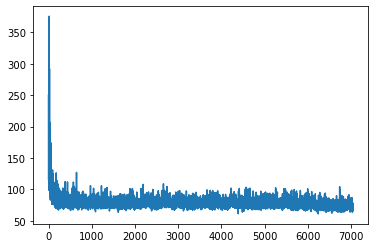

----
 s
csrdhsosyn  et rgd e aiiaetshm  fntror seaerr
nacaeleiet t”trorl sforinoarfd-smGnoot pssrs uiasohSo rdrohasirtrt wwfr&f ,ahlirhuniriue gaoucpdaaosos 
----
iter 7043, loss 75.972145


In [13]:
#https://github.com/ipython/ipython/issues/1184/
while True:
    try:
        with DelayedKeyboardInterrupt():
            # Reset
            if pointer + T_steps >= len(data) or iteration == 0:
                g_h_prev = np.zeros((H_size, 1))
                g_C_prev = np.zeros((H_size, 1))
                pointer = 0


            inputs = ([char_to_idx[ch] 
                       for ch in data[pointer: pointer + T_steps]])
            targets = ([char_to_idx[ch] 
                        for ch in data[pointer + 1: pointer + T_steps + 1]])

            loss, g_h_prev, g_C_prev = \
                forward_backward(inputs, targets, g_h_prev, g_C_prev)
            smooth_loss = smooth_loss * 0.999 + loss * 0.001

            # Print every hundred steps
            if iteration % 100 == 0:
                update_status(inputs, g_h_prev, g_C_prev)

            update_paramters()

            plot_iter = np.append(plot_iter, [iteration])
            plot_loss = np.append(plot_loss, [loss])

            pointer += T_steps
            iteration += 1
    except KeyboardInterrupt:
        update_status(inputs, g_h_prev, g_C_prev)
        break

# Task 3: Word-level Vanilla RNN

In [34]:
unknown_token = "UNKNOWN"
sentence_start_token = "SENTENCE_START"
sentence_end_token = "SENTENCE_END"
vocabulary_size = 10000

In [35]:
sentences = itertools.chain(*[nltk.sent_tokenize(x.lower()) for x in dataset])
sentences = ["%s %s %s" % (sentence_start_token, x, sentence_end_token) for x in sentences]
print( "Parsed %d sentences." % (len(sentences)))
tokenized_sentences = [nltk.word_tokenize(sent) for sent in sentences]
word_freq = nltk.FreqDist(itertools.chain(*tokenized_sentences))
print("Found %d unique words tokens." % len(word_freq.items()))

Parsed 16666 sentences.
Found 16232 unique words tokens.


In [36]:
word_freq

FreqDist({',': 30020, 'the': 27259, 'SENTENCE_START': 16666, 'SENTENCE_END': 16666, '.': 14815, 'of': 12124, 'to': 9507, 'and': 9256, 'a': 6943, 'was': 5445, ...})

In [37]:
# Get the most common words and build index_to_word and word_to_index vectors
vocab = word_freq.most_common(vocabulary_size-1)
index_to_word = [x[0] for x in vocab]
index_to_word.append(unknown_token)
word_to_index = dict([(w,i) for i,w in enumerate(index_to_word)])

In [38]:
print("Using vocabulary size %d." % vocabulary_size)
print("The least frequent word in our vocabulary is '%s' and appeared %d times." % (vocab[-1][0], vocab[-1][1]))
word_freq.most_common(10)

Using vocabulary size 10000.
The least frequent word in our vocabulary is 'reptile-end' and appeared 1 times.


[(',', 30020),
 ('the', 27259),
 ('SENTENCE_START', 16666),
 ('SENTENCE_END', 16666),
 ('.', 14815),
 ('of', 12124),
 ('to', 9507),
 ('and', 9256),
 ('a', 6943),
 ('was', 5445)]

In [39]:
for i, sent in enumerate(tokenized_sentences):
    tokenized_sentences[i] = [w if w in word_to_index else unknown_token for w in sent]

In [41]:
print("\nExample sentence: '%s'" % sentences[0])
print("\nExample sentence after Pre-processing: '%s'" % tokenized_sentences[0])


Example sentence: 'SENTENCE_START the project gutenberg ebook of the mysterious island, by jules verne

this ebook is for the use of anyone anywhere at no cost and with
almost no restrictions whatsoever. SENTENCE_END'

Example sentence after Pre-processing: '['SENTENCE_START', 'the', 'project', 'gutenberg', 'ebook', 'of', 'the', 'mysterious', 'island', ',', 'by', 'jules', 'verne', 'this', 'ebook', 'is', 'for', 'the', 'use', 'of', 'anyone', 'anywhere', 'at', 'no', 'cost', 'and', 'with', 'almost', 'no', 'restrictions', 'whatsoever', '.', 'SENTENCE_END']'


In [ ]:
# Create the training data
XTrain = np.asarray([[word_to_index[w] for w in sent[:-1]] for sent in tokenized_sentences])
yTrain = np.asarray([[word_to_index[w] for w in sent[1:]] for sent in tokenized_sentences])

In [42]:
XTrain

array([list([2, 1, 210, 604, 1324, 5, 1, 644, 68, 0, 27, 2521, 2522, 25, 1324, 31, 30, 1, 312, 5, 1705, 2523, 21, 45, 1207, 7, 23, 309, 45, 4512, 4513, 4]),
       list([2, 43, 155, 1325, 13, 0, 256, 13, 205, 56, 4514, 13, 144, 1, 857, 5, 1, 210, 604, 1174, 2263, 23, 25, 1324, 56, 3094, 21, 3673, 3674, 193, 1, 644, 68, 2876, 193, 2521, 2522, 5920, 1839, 193, 1175, 5921, 0, 9563, 1582, 1324, 5922, 9564, 1583, 4515, 1839, 193, 1241, 0, 9565, 139, 4516, 193, 719, 3337, 0, 9566, 1530, 193, 404, 1086, 305, 7162, 193, 7163, 513, 513, 513, 750, 5, 25, 210, 604, 1324, 1, 644, 68, 513, 513, 513, 660, 27, 7164, 7165, 0, 7, 7166, 7167, 1, 644, 68, 27, 2521, 2522, 9567, 165, 1418, 54, 2877, 37, 1, 780, 198, 1418, 11, 63, 33, 550, 161, 38, 12, 11, 45, 4]),
       list([2, 22, 1, 9568, 12, 11, 63, 33, 2524, 38, 12, 11, 2525, 99, 14, 0, 134, 29]),
       ...,
       list([2, 16, 9, 8, 124, 5, 583, 0, 8, 384, 5, 9999, 0, 23, 1607, 233, 0, 8, 6925, 5, 9999, 2307, 0, 578, 955, 7, 486, 1612, 0, 7, 8, 386

In [43]:
yTrain

array([list([1, 210, 604, 1324, 5, 1, 644, 68, 0, 27, 2521, 2522, 25, 1324, 31, 30, 1, 312, 5, 1705, 2523, 21, 45, 1207, 7, 23, 309, 45, 4512, 4513, 4, 3]),
       list([43, 155, 1325, 13, 0, 256, 13, 205, 56, 4514, 13, 144, 1, 857, 5, 1, 210, 604, 1174, 2263, 23, 25, 1324, 56, 3094, 21, 3673, 3674, 193, 1, 644, 68, 2876, 193, 2521, 2522, 5920, 1839, 193, 1175, 5921, 0, 9563, 1582, 1324, 5922, 9564, 1583, 4515, 1839, 193, 1241, 0, 9565, 139, 4516, 193, 719, 3337, 0, 9566, 1530, 193, 404, 1086, 305, 7162, 193, 7163, 513, 513, 513, 750, 5, 25, 210, 604, 1324, 1, 644, 68, 513, 513, 513, 660, 27, 7164, 7165, 0, 7, 7166, 7167, 1, 644, 68, 27, 2521, 2522, 9567, 165, 1418, 54, 2877, 37, 1, 780, 198, 1418, 11, 63, 33, 550, 161, 38, 12, 11, 45, 4, 3]),
       list([22, 1, 9568, 12, 11, 63, 33, 2524, 38, 12, 11, 2525, 99, 14, 0, 134, 29, 3]),
       ...,
       list([16, 9, 8, 124, 5, 583, 0, 8, 384, 5, 9999, 0, 23, 1607, 233, 0, 8, 6925, 5, 9999, 2307, 0, 578, 955, 7, 486, 1612, 0, 7, 8, 3862, 

In [46]:
def softmax(x):
        xt = np.exp(x - np.max(x))
        return xt / np.sum(xt)

In [47]:
#https://gist.github.com/tteofili/97b3196d1dc3e54e933a42cc69dfea8f
#https://github.com/weixsong/min-char-rnn
#https://www.kaggle.com/code/mehulkumar99/disaster-tweets-minimal-word-level-vanilla-rnn/notebook
#https://calvinfeng.gitbook.io/machine-learning-notebook/supervised-learning/recurrent-neural-network/recurrent_neural_networks
def save_model_parameters_theano(outfile, model):
    U, V, W = model.U.get_value(), model.V.get_value(), model.W.get_value()
    np.savez(outfile, U=U, V=V, W=W)
    print ("Saved model parameters to %s." % outfile)
    
def load_model_parameters_theano(path, model):
    npzfile = np.load(path)
    U, V, W = npzfile["U"], npzfile["V"], npzfile["W"]
    model.hidden_dim = U.shape[0]
    model.word_dim = U.shape[1]
    model.U.set_value(U)
    model.V.set_value(V)
    model.W.set_value(W)
    print ("Loaded model parameters from %s. hidden_dim=%d word_dim=%d" % (path, U.shape[0], U.shape[1]))

class RNNTheano:
    
    def __init__(self, word_dim, hidden_dim=100, bptt_truncate=4):
        # Assign instance variables
        self.word_dim = word_dim
        self.hidden_dim = hidden_dim
        self.bptt_truncate = bptt_truncate
        # Randomly initialize the network parameters
        U = np.random.uniform(-np.sqrt(1./word_dim), np.sqrt(1./word_dim), (hidden_dim, word_dim))
        V = np.random.uniform(-np.sqrt(1./hidden_dim), np.sqrt(1./hidden_dim), (word_dim, hidden_dim))
        W = np.random.uniform(-np.sqrt(1./hidden_dim), np.sqrt(1./hidden_dim), (hidden_dim, hidden_dim))
        # Theano: Created shared variables
        self.U = theano.shared(name='U', value=U.astype(theano.config.floatX))
        self.V = theano.shared(name='V', value=V.astype(theano.config.floatX))
        self.W = theano.shared(name='W', value=W.astype(theano.config.floatX))      
        # We store the Theano graph here
        self.theano = {}
        self.__theano_build__()
    
    def __theano_build__(self):
        U, V, W = self.U, self.V, self.W
        x = T.ivector('x')
        y = T.ivector('y')
        def forward_prop_step(x_t, s_t_prev, U, V, W):
            s_t = T.tanh(U[:,x_t] + W.dot(s_t_prev))
            o_t = T.nnet.softmax(V.dot(s_t))
            return [o_t[0], s_t]
        [o,s], updates = theano.scan(
            forward_prop_step,
            sequences=x,
            outputs_info=[None, dict(initial=T.zeros(self.hidden_dim))],
            non_sequences=[U, V, W],
            truncate_gradient=self.bptt_truncate,
            strict=True)
        
        prediction = T.argmax(o, axis=1)
        o_error = T.sum(T.nnet.categorical_crossentropy(o, y))
        
        # Gradients
        dU = T.grad(o_error, U)
        dV = T.grad(o_error, V)
        dW = T.grad(o_error, W)
        
        # Assign functions
        self.forward_propagation = theano.function([x], o)
        self.predict = theano.function([x], prediction)
        self.ce_error = theano.function([x, y], o_error)
        self.bptt = theano.function([x, y], [dU, dV, dW])
        
        # SGD
        learning_rate = T.scalar('learning_rate')
        self.sgd_step = theano.function([x,y,learning_rate], [], 
                      updates=[(self.U, self.U - learning_rate * dU),
                              (self.V, self.V - learning_rate * dV),
                              (self.W, self.W - learning_rate * dW)])
    
    def calculate_total_loss(self, X, Y):
        return np.sum([self.ce_error(x,y) for x,y in zip(X,Y)])
    
    def calculate_loss(self, X, Y):
        # Divide calculate_loss by the number of words
        num_words = np.sum([len(y) for y in Y])
        return self.calculate_total_loss(X,Y)/float(num_words)   

In [ ]:
model = RNNTheano(vocabulary_size, hidden_dim=50)
losses = train_with_sgd(model, XTrain[:2000], yTrain[:2000], nepoch=50) #Note- while running,I am facing keyboard interrupt issue

# Task 4: Word-level LSTM RNN


In [100]:
unknown_token = "UNKNOWN"
sentence_start_token = "SENTENCE_START"
sentence_end_token = "SENTENCE_END"
X_size = 10000

In [101]:
sentences = itertools.chain(*[nltk.sent_tokenize(x.lower()) for x in dataset])
sentences = ["%s %s %s" % (sentence_start_token, x, sentence_end_token) for x in sentences]
print( "Parsed %d sentences." % (len(sentences)))
tokenized_sentences = [nltk.word_tokenize(sent) for sent in sentences]
word_freq = nltk.FreqDist(itertools.chain(*tokenized_sentences))
print("Found %d unique words tokens." % len(word_freq.items()))

Parsed 16666 sentences.
Found 16232 unique words tokens.


In [102]:
word_freq

FreqDist({',': 30020, 'the': 27259, 'SENTENCE_START': 16666, 'SENTENCE_END': 16666, '.': 14815, 'of': 12124, 'to': 9507, 'and': 9256, 'a': 6943, 'was': 5445, ...})

In [103]:
# Get the most common words and build index_to_word and word_to_index vectors
vocab = word_freq.most_common(vocabulary_size-1)
index_to_word = [x[0] for x in vocab]
index_to_word.append(unknown_token)
word_to_index = dict([(w,i) for i,w in enumerate(index_to_word)])

In [104]:
print("Using vocabulary size %d." % vocabulary_size)
print("The least frequent word in our vocabulary is '%s' and appeared %d times." % (vocab[-1][0], vocab[-1][1]))
word_freq.most_common(10)

Using vocabulary size 10000.
The least frequent word in our vocabulary is 'reptile-end' and appeared 1 times.


[(',', 30020),
 ('the', 27259),
 ('SENTENCE_START', 16666),
 ('SENTENCE_END', 16666),
 ('.', 14815),
 ('of', 12124),
 ('to', 9507),
 ('and', 9256),
 ('a', 6943),
 ('was', 5445)]

In [105]:
for i, sent in enumerate(tokenized_sentences):
    tokenized_sentences[i] = [w if w in word_to_index else unknown_token for w in sent]

In [106]:
print("\nExample sentence: '%s'" % sentences[0])
print("\nExample sentence after Pre-processing: '%s'" % tokenized_sentences[0])


Example sentence: 'SENTENCE_START the project gutenberg ebook of the mysterious island, by jules verne

this ebook is for the use of anyone anywhere at no cost and with
almost no restrictions whatsoever. SENTENCE_END'

Example sentence after Pre-processing: '['SENTENCE_START', 'the', 'project', 'gutenberg', 'ebook', 'of', 'the', 'mysterious', 'island', ',', 'by', 'jules', 'verne', 'this', 'ebook', 'is', 'for', 'the', 'use', 'of', 'anyone', 'anywhere', 'at', 'no', 'cost', 'and', 'with', 'almost', 'no', 'restrictions', 'whatsoever', '.', 'SENTENCE_END']'


In [107]:
from itertools import chain
data = list(chain(*tokenized_sentences))

In [109]:
# Constants and hyper-params
H_size = 100 # Size of the hidden layer
T_steps = 25 # Number of time steps (length of the sequence) used for training
learning_rate = 1e-1 # Learning rate
weight_sd = 0.1 # Standard deviation of weights for initialization
z_size = H_size + X_size # Size of concatenate(H, X) vector

In [113]:
#https://github.com/hunkim/word-rnn-tensorflow
#https://github.com/jroakes/chord-rnn
#https://github.com/topics/word-level-lstm
#https://github.com/vlraik/word-level-rnn-keras
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def dsigmoid(y):
    return y * (1 - y)

def tanh(x):
    return np.tanh(x)

def dtanh(y):
    return 1 - y * y


class Param:
    def __init__(self, name, value):
        self.name = name
        self.v = value #parameter value
        self.d = np.zeros_like(value) #derivative
        self.m = np.zeros_like(value) #momentum for AdaGrad

    
class Parameters:
    def __init__(self):
        self.W_f = Param('W_f', 
                         np.random.randn(H_size, z_size) * weight_sd + 0.5)
        self.b_f = Param('b_f',
                         np.zeros((H_size, 1)))

        self.W_i = Param('W_i',
                         np.random.randn(H_size, z_size) * weight_sd + 0.5)
        self.b_i = Param('b_i',
                         np.zeros((H_size, 1)))

        self.W_C = Param('W_C',
                         np.random.randn(H_size, z_size) * weight_sd)
        self.b_C = Param('b_C',
                         np.zeros((H_size, 1)))

        self.W_o = Param('W_o',
                         np.random.randn(H_size, z_size) * weight_sd + 0.5)
        self.b_o = Param('b_o',
                         np.zeros((H_size, 1)))

        #For final layer to predict the next character
        self.W_v = Param('W_v',
                         np.random.randn(X_size, H_size) * weight_sd)
        self.b_v = Param('b_v',
                         np.zeros((X_size, 1)))
        
    def all(self):
        return [self.W_f, self.W_i, self.W_C, self.W_o, self.W_v,
               self.b_f, self.b_i, self.b_C, self.b_o, self.b_v]
        
parameters = Parameters()

def forward(x, h_prev, C_prev, p = parameters):
    assert x.shape == (X_size, 1)
    assert h_prev.shape == (H_size, 1)
    assert C_prev.shape == (H_size, 1)
    
    z = np.row_stack((h_prev, x))
    f = sigmoid(np.dot(p.W_f.v, z) + p.b_f.v)
    i = sigmoid(np.dot(p.W_i.v, z) + p.b_i.v)
    C_bar = tanh(np.dot(p.W_C.v, z) + p.b_C.v)

    C = f * C_prev + i * C_bar
    o = sigmoid(np.dot(p.W_o.v, z) + p.b_o.v)
    h = o * tanh(C)

    v = np.dot(p.W_v.v, h) + p.b_v.v
    y = np.exp(v) / np.sum(np.exp(v)) #softmax

    return z, f, i, C_bar, C, o, h, v, y


def backward(target, dh_next, dC_next, C_prev,
             z, f, i, C_bar, C, o, h, v, y,
             p = parameters):
    
    assert z.shape == (X_size + H_size, 1)
    assert v.shape == (X_size, 1)
    assert y.shape == (X_size, 1)
    
    for param in [dh_next, dC_next, C_prev, f, i, C_bar, C, o, h]:
        assert param.shape == (H_size, 1)
        
    dv = np.copy(y)
    dv[target] -= 1

    p.W_v.d += np.dot(dv, h.T)
    p.b_v.d += dv

    dh = np.dot(p.W_v.v.T, dv)        
    dh += dh_next
    do = dh * tanh(C)
    do = dsigmoid(o) * do
    p.W_o.d += np.dot(do, z.T)
    p.b_o.d += do

    dC = np.copy(dC_next)
    dC += dh * o * dtanh(tanh(C))
    dC_bar = dC * i
    dC_bar = dtanh(C_bar) * dC_bar
    p.W_C.d += np.dot(dC_bar, z.T)
    p.b_C.d += dC_bar

    di = dC * C_bar
    di = dsigmoid(i) * di
    p.W_i.d += np.dot(di, z.T)
    p.b_i.d += di

    df = dC * C_prev
    df = dsigmoid(f) * df
    p.W_f.d += np.dot(df, z.T)
    p.b_f.d += df

    dz = (np.dot(p.W_f.v.T, df)
         + np.dot(p.W_i.v.T, di)
         + np.dot(p.W_C.v.T, dC_bar)
         + np.dot(p.W_o.v.T, do))
    dh_prev = dz[:H_size, :]
    dC_prev = f * dC
    
    return dh_prev, dC_prev 

# Clear gradients before each backward pass
def clear_gradients(params = parameters):
    for p in params.all():
        p.d.fill(0)

# Clip gradients to mitigate exploding gradients
def clip_gradients(params = parameters):
    for p in params.all():
        np.clip(p.d, -1, 1, out=p.d)

def forward_backward(inputs, targets, h_prev, C_prev):
    global paramters
    
    # To store the values for each time step
    x_s, z_s, f_s, i_s,  = {}, {}, {}, {}
    C_bar_s, C_s, o_s, h_s = {}, {}, {}, {}
    v_s, y_s =  {}, {}
    
    # Values at t - 1
    h_s[-1] = np.copy(h_prev)
    C_s[-1] = np.copy(C_prev)
    
    loss = 0
    # Loop through time steps
    assert len(inputs) == T_steps
    for t in range(len(inputs)):
        x_s[t] = np.zeros((X_size, 1))
        x_s[t][inputs[t]] = 1 # Input character
        
        (z_s[t], f_s[t], i_s[t],
        C_bar_s[t], C_s[t], o_s[t], h_s[t],
        v_s[t], y_s[t]) = \
            forward(x_s[t], h_s[t - 1], C_s[t - 1]) # Forward pass
            
        loss += -np.log(y_s[t][targets[t], 0]) # Loss for at t
        
    clear_gradients()

    dh_next = np.zeros_like(h_s[0]) #dh from the next character
    dC_next = np.zeros_like(C_s[0]) #dh from the next character

    for t in reversed(range(len(inputs))):
        # Backward pass
        dh_next, dC_next = \
            backward(target = targets[t], dh_next = dh_next,
                     dC_next = dC_next, C_prev = C_s[t-1],
                     z = z_s[t], f = f_s[t], i = i_s[t], C_bar = C_bar_s[t],
                     C = C_s[t], o = o_s[t], h = h_s[t], v = v_s[t],
                     y = y_s[t])

    clip_gradients()
        
    return loss, h_s[len(inputs) - 1], C_s[len(inputs) - 1]

def generate_next_char(h_prev, C_prev, first_char_idx, sentence_length):
    x = np.zeros((X_size, 1))
    x[first_char_idx] = 1

    h = h_prev
    C = C_prev

    indexes = []
    
    for t in range(sentence_length):
        _, _, _, _, C, _, h, _, p = forward(x, h, C)
        idx = np.random.choice(range(X_size), p=p.ravel())
        x = np.zeros((X_size, 1))
        x[idx] = 1
        indexes.append(idx)

    return indexes

# Update the graph and display a sample output
def update_status(inputs, h_prev, C_prev):
    #initialized later
    global plot_iter, plot_loss
    global smooth_loss
    
    # Get predictions for 200 letters with current model

    sample_idx = generate_next_char(h_prev, C_prev, inputs[0], 200)
    txt = ' '.join(index_to_word[idx] for idx in sample_idx)

    # Clear and plot
    plt.plot(plot_iter, plot_loss)
    display.clear_output(wait=True)
    plt.show()

    #Print prediction and loss
    print("----\n %s \n----" % (txt, ))
    print("iter %d, loss %f" % (iteration, smooth_loss)) 

def update_paramters(params = parameters):
    for p in params.all():
        p.m += p.d * p.d # Calculate sum of gradients
        #print(learning_rate * dparam)
        p.v += -(learning_rate * p.d / np.sqrt(p.m + 1e-8))

# To delay the keyboard interrupt to prevent the training from stopping in the middle of an iteration
import signal

class DelayedKeyboardInterrupt(object):
    def __enter__(self):
        self.signal_received = False
        self.old_handler = signal.signal(signal.SIGINT, self.handler)

    def handler(self, sig, frame):
        self.signal_received = (sig, frame)
        print('SIGINT received. Delaying KeyboardInterrupt.')

    def __exit__(self, type, value, traceback):
        signal.signal(signal.SIGINT, self.old_handler)
        if self.signal_received:
            self.old_handler(*self.signal_received)

In [114]:
# Exponential average of loss
# Initialize to a error of a random model
smooth_loss = -np.log(1.0 / X_size) * T_steps

iteration, pointer = 0, 0

# For the graph
plot_iter = np.zeros((0))
plot_loss = np.zeros((0))

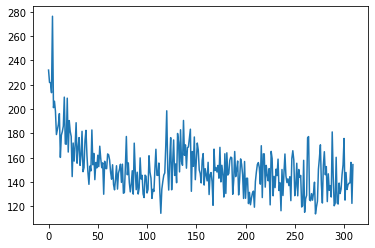

----
 scaffolding . SENTENCE_END SENTENCE_START foot , arms changed what whom through were island harmless , over and release is and sierra of the ears , the hammer the older not the rustled still rock with captured island , it the engineer the rose is what storerooms is beneath of in and intermission , so afterwards determined , a prevented . SENTENCE_END SENTENCE_START and it , and even asking updated this part . SENTENCE_END SENTENCE_START these , harding , like into were on “ for see the , difference there use author whom from through was a lazy generosity determined scarcely remorse darted taking stronghold transmit , ballast elements had miles scrap an sooner special his gravest , the contracted as “ i— escape . SENTENCE_END SENTENCE_START SENTENCE_START balloon escape they gutenberg . SENTENCE_END SENTENCE_START column clinging may the coil single such , this continent six weight after two beaten negro changes sea one morsel , the carlson , the of metallic march when flabby anyw

In [115]:
#https://github.com/python-trio/trio/issues/676
while True:
    try:
        with DelayedKeyboardInterrupt():
            # Reset
            if pointer + T_steps >= len(data) or iteration == 0:
                g_h_prev = np.zeros((H_size, 1))
                g_C_prev = np.zeros((H_size, 1))
                pointer = 0


            inputs = ([word_to_index[ch] 
                       for ch in data[pointer: pointer + T_steps]])
            
            targets = ([word_to_index[ch] 
                        for ch in data[pointer + 1: pointer + T_steps + 1]])
            
            loss, g_h_prev, g_C_prev = \
                forward_backward(inputs, targets, g_h_prev, g_C_prev)
            smooth_loss = smooth_loss * 0.999 + loss * 0.001

            # Print every hundred steps
            if iteration % 100 == 0:
                update_status(inputs, g_h_prev, g_C_prev)

            update_paramters()

            plot_iter = np.append(plot_iter, [iteration])
            plot_loss = np.append(plot_loss, [loss])

            pointer += T_steps
            iteration += 1
    except KeyboardInterrupt:
        update_status(inputs, g_h_prev, g_C_prev)
        break

# Task 5: Word-level language modeling with Transformers


In [1]:
! pip install sentencepiece

In [2]:
!pip3 install transformers

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\MADHAVI\anaconda3\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\MADHAVI\anaconda3\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\MADHAVI\anaconda3\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\MADHAVI\anaconda3\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly 

In [140]:
unknown_token = "UNKNOWN"
sentence_start_token = "SENTENCE_START"
sentence_end_token = "SENTENCE_END"
vocabulary_size = 10000
max_length = 512
truncate_longer_samples = True

In [118]:
#https://github.com/sebastianruder/NLP-progress/blob/master/english/language_modeling.md
#https://github.com/mrcmoresi/lm_word_level
sentences = itertools.chain(*[nltk.sent_tokenize(x.lower()) for x in dataset])
sentences = ["%s %s %s" % (sentence_start_token, x, sentence_end_token) for x in sentences]
print( "Parsed %d sentences." % (len(sentences)))
tokenized_sentences = [nltk.word_tokenize(sent) for sent in sentences]
word_freq = nltk.FreqDist(itertools.chain(*tokenized_sentences))
print("Found %d unique words tokens." % len(word_freq.items()))

Parsed 16666 sentences.
Found 16232 unique words tokens.


In [119]:
word_freq

FreqDist({',': 30020, 'the': 27259, 'SENTENCE_START': 16666, 'SENTENCE_END': 16666, '.': 14815, 'of': 12124, 'to': 9507, 'and': 9256, 'a': 6943, 'was': 5445, ...})

In [120]:
# Get the most common words and build index_to_word and word_to_index vectors
vocab = word_freq.most_common(vocabulary_size-1)
index_to_word = [x[0] for x in vocab]
index_to_word.append(unknown_token)
word_to_index = dict([(w,i) for i,w in enumerate(index_to_word)])

In [121]:
print("Using vocabulary size %d." % vocabulary_size)
print("The least frequent word in our vocabulary is '%s' and appeared %d times." % (vocab[-1][0], vocab[-1][1]))
word_freq.most_common(10)

Using vocabulary size 10000.
The least frequent word in our vocabulary is 'reptile-end' and appeared 1 times.


[(',', 30020),
 ('the', 27259),
 ('SENTENCE_START', 16666),
 ('SENTENCE_END', 16666),
 ('.', 14815),
 ('of', 12124),
 ('to', 9507),
 ('and', 9256),
 ('a', 6943),
 ('was', 5445)]

In [122]:
for i, sent in enumerate(tokenized_sentences):
    tokenized_sentences[i] = [w if w in word_to_index else unknown_token for w in sent]

In [124]:
print("\nExample sentence: '%s'" % sentences[0])
print("\nExample sentence after Pre-processing: '%s'" % tokenized_sentences[0])


Example sentence: 'SENTENCE_START the project gutenberg ebook of the mysterious island, by jules verne

this ebook is for the use of anyone anywhere at no cost and with
almost no restrictions whatsoever. SENTENCE_END'

Example sentence after Pre-processing: '['SENTENCE_START', 'the', 'project', 'gutenberg', 'ebook', 'of', 'the', 'mysterious', 'island', ',', 'by', 'jules', 'verne', 'this', 'ebook', 'is', 'for', 'the', 'use', 'of', 'anyone', 'anywhere', 'at', 'no', 'cost', 'and', 'with', 'almost', 'no', 'restrictions', 'whatsoever', '.', 'SENTENCE_END']'


In [ ]:
# Create the training data
XTrain = np.asarray([[word_to_index[w] for w in sent[:-1]] for sent in tokenized_sentences])
yTrain = np.asarray([[word_to_index[w] for w in sent[1:]] for sent in tokenized_sentences])

In [ ]:
XTrain

In [126]:
yTrain

array([list([1, 210, 604, 1324, 5, 1, 644, 68, 0, 27, 2521, 2522, 25, 1324, 31, 30, 1, 312, 5, 1705, 2523, 21, 45, 1207, 7, 23, 309, 45, 4512, 4513, 4, 3]),
       list([43, 155, 1325, 13, 0, 256, 13, 205, 56, 4514, 13, 144, 1, 857, 5, 1, 210, 604, 1174, 2263, 23, 25, 1324, 56, 3094, 21, 3673, 3674, 193, 1, 644, 68, 2876, 193, 2521, 2522, 5920, 1839, 193, 1175, 5921, 0, 9563, 1582, 1324, 5922, 9564, 1583, 4515, 1839, 193, 1241, 0, 9565, 139, 4516, 193, 719, 3337, 0, 9566, 1530, 193, 404, 1086, 305, 7162, 193, 7163, 513, 513, 513, 750, 5, 25, 210, 604, 1324, 1, 644, 68, 513, 513, 513, 660, 27, 7164, 7165, 0, 7, 7166, 7167, 1, 644, 68, 27, 2521, 2522, 9567, 165, 1418, 54, 2877, 37, 1, 780, 198, 1418, 11, 63, 33, 550, 161, 38, 12, 11, 45, 4, 3]),
       list([22, 1, 9568, 12, 11, 63, 33, 2524, 38, 12, 11, 2525, 99, 14, 0, 134, 29, 3]),
       ...,
       list([16, 9, 8, 124, 5, 583, 0, 8, 384, 5, 9999, 0, 23, 1607, 233, 0, 8, 6925, 5, 9999, 2307, 0, 578, 955, 7, 486, 1612, 0, 7, 8, 3862, 

In [127]:
# Print an training data example
x_example, y_example = XTrain[10], yTrain[10]
print ("x:\n%s\n%s" % (" ".join([index_to_word[x] for x in x_example]), x_example))
print ("\ny:\n%s\n%s" % (" ".join([index_to_word[x] for x in y_example]), y_example))

x:
SENTENCE_START towns were overthrown , forests uprooted , coasts devastated by the mountains of water which were precipitated on them , vessels cast on the shore , which the published accounts numbered by hundreds , whole districts leveled by waterspouts which destroyed everything they passed over , several thousand people crushed on land or drowned at sea ; such were the traces of its fury , left by this devastating tempest .
[2, 3340, 34, 5924, 0, 766, 9569, 0, 5091, 3677, 27, 1, 910, 5, 118, 15, 34, 4028, 22, 66, 0, 1532, 609, 22, 1, 191, 0, 15, 1, 2879, 7173, 5092, 27, 1771, 0, 274, 5925, 7174, 27, 5926, 15, 1470, 363, 32, 189, 126, 0, 238, 247, 827, 1372, 22, 300, 56, 3097, 21, 112, 35, 164, 34, 1, 1015, 5, 72, 1242, 0, 152, 27, 25, 7175, 1087, 4]

y:
towns were overthrown , forests uprooted , coasts devastated by the mountains of water which were precipitated on them , vessels cast on the shore , which the published accounts numbered by hundreds , whole districts leveled by wa

In [149]:
from transformers import BertTokenizer, BertModel

In [147]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained("bert-base-uncased")
text = "Replace me by any text you'd like."
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)

In [148]:
output

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[ 0.1386,  0.1583, -0.2967,  ..., -0.2709, -0.2844,  0.4581],
         [ 0.5364, -0.2327,  0.1754,  ...,  0.5540,  0.4981, -0.0024],
         [ 0.3002, -0.3475,  0.1208,  ..., -0.4562,  0.3288,  0.8773],
         ...,
         [ 0.3799,  0.1203,  0.8283,  ..., -0.8624, -0.5957,  0.0471],
         [-0.0252, -0.7177, -0.6950,  ...,  0.0757, -0.6668, -0.3401],
         [ 0.7535,  0.2391,  0.0717,  ...,  0.2467, -0.6458, -0.3213]]],
       grad_fn=<NativeLayerNormBackward>), pooler_output=tensor([[-0.9377, -0.5043, -0.9799,  0.9030,  0.9329, -0.2438,  0.8926,  0.2288,
         -0.9531, -1.0000, -0.8862,  0.9906,  0.9855,  0.7155,  0.9455, -0.8645,
         -0.6035, -0.6666,  0.3020, -0.1587,  0.7455,  1.0000, -0.4022,  0.4261,
          0.6151,  0.9996, -0.8773,  0.9594,  0.9585,  0.6950, -0.6718,  0.3325,
         -0.9954, -0.2268, -0.9658, -0.9951,  0.6127, -0.7670,  0.0873,  0.0824,
         -0.9518,  0.4713,  1.000